<a href="https://colab.research.google.com/github/JeromeVeix/Sentiment-analysis/blob/main/emotions_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-plot

In [ ]:
!pip install nltk
!pip install wordcloud

In [ ]:
!pip install scipy==1.11.4

In [ ]:
from scikitplot.metrics import plot_confusion_matrix

In [ ]:
#plt.style.available

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style,rcParams #pleasing visualization
style.use('seaborn-v0_8-whitegrid')
rcParams['figure.figsize'] = 10,5
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud #visualization tools representing of words in a text
import re
import nltk
nltk.download('stopwords') #words that can be ignored 'a', 'the', 'and'
nltk.download('wordnet') #a lexical database for the english language
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #root of the word running-run
from sklearn.feature_extraction.text import CountVectorizer #matrix in which unique words are stored
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, classification_report #classifcation shows curve
from scikitplot.metrics import plot_confusion_matrix

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df = pd.read_csv('emotions.csv', delimiter=',', names=['text','label'])
df.head()

,text,label
0,That game hurt.,sadness
1,Man I love reddit.,love
2,"[NAME] was nowhere near them, he was by the Fa...",neutral
3,Right? Considering itâs such an important do...,gratitude
4,"He isn't as big, but he's still quite popular....",disapproval


In [ ]:
print('Shape of the DataFrame:',df.shape) #view the shape (number of records) in the dataframe

Shape of the DataFrame: (67206, 2)


In [ ]:
df['label'].unique #unique emotion, occuring in the dataframe only once

<bound method Series.unique of 0            sadness
1               love
2            neutral
3          gratitude
4        disapproval
            ...     
67201        neutral
67202     admiration
67203      curiosity
67204        neutral
67205        sadness
Name: label, Length: 67206, dtype: object>

In [ ]:
df[df[['label']].duplicated()] #the emotions occuring more than once

,text,label
6,Sponge Blurb Pubs Quaw Haha GURR ha AAa! final...,amusement
7,"I have, and now that you mention it, I think t...",neutral
9,BUT IT'S HER TURN! /s,neutral
10,That is odd.,disappointment
11,Build a wall? /jk,neutral
...,...,...
67201,"Before we continue, I would first like to ask ...",neutral
67202,This is great! Can anyone make a request with ...,admiration
67203,Iâm sorry. Can you please explain what are t...,curiosity
67204,No but it should be,neutral


In [ ]:
def custom_encoder(df): #making the emotions binaries: positive emotion=1, negative emotion=0
  df.replace(to_replace='love', value=1, inplace=True)
  df.replace(to_replace='gratitude', value=1, inplace=True)
  df.replace(to_replace='admiration', value=1, inplace=True)
  df.replace(to_replace='curiosity', value=1, inplace=True)
  df.replace(to_replace='amusement', value=1, inplace=True)
  df.replace(to_replace='realization', value=1, inplace=True)
  df.replace(to_replace='joy', value=1, inplace=True)
  df.replace(to_replace='optimism', value=1, inplace=True)
  df.replace(to_replace='caring', value=1, inplace=True)
  df.replace(to_replace='excitement', value=1, inplace=True)
  df.replace(to_replace='relief', value=1, inplace=True)
  df.replace(to_replace='surprise', value=1, inplace=True)
  df.replace(to_replace='approval', value=1, inplace=True)
  df.replace(to_replace='confusion', value=0, inplace=True)
  df.replace(to_replace='embarrassment', value=0, inplace=True)
  df.replace(to_replace='anger', value=0, inplace=True)
  df.replace(to_replace='disapproval', value=0, inplace=True)
  df.replace(to_replace='sadness', value=0, inplace=True)
  df.replace(to_replace='neutral', value=0, inplace=True)
  df.replace(to_replace='disappointment', value=0, inplace=True)
  df.replace(to_replace='grief', value=0, inplace=True)
  df.replace(to_replace='remorse', value=0, inplace=True)
  df.replace(to_replace='desire', value=0, inplace=True)
  df.replace(to_replace='nervousness', value=0, inplace=True)
  df.replace(to_replace='fear', value=0, inplace=True)
  df.replace(to_replace='disgust', value=0, inplace=True)
  df.replace(to_replace='pride', value=1, inplace=True)
  df.replace(to_replace='annoyance', value=0, inplace=True)

In [ ]:
#execute custom encoder function against the dataset
custom_encoder(df['label'])

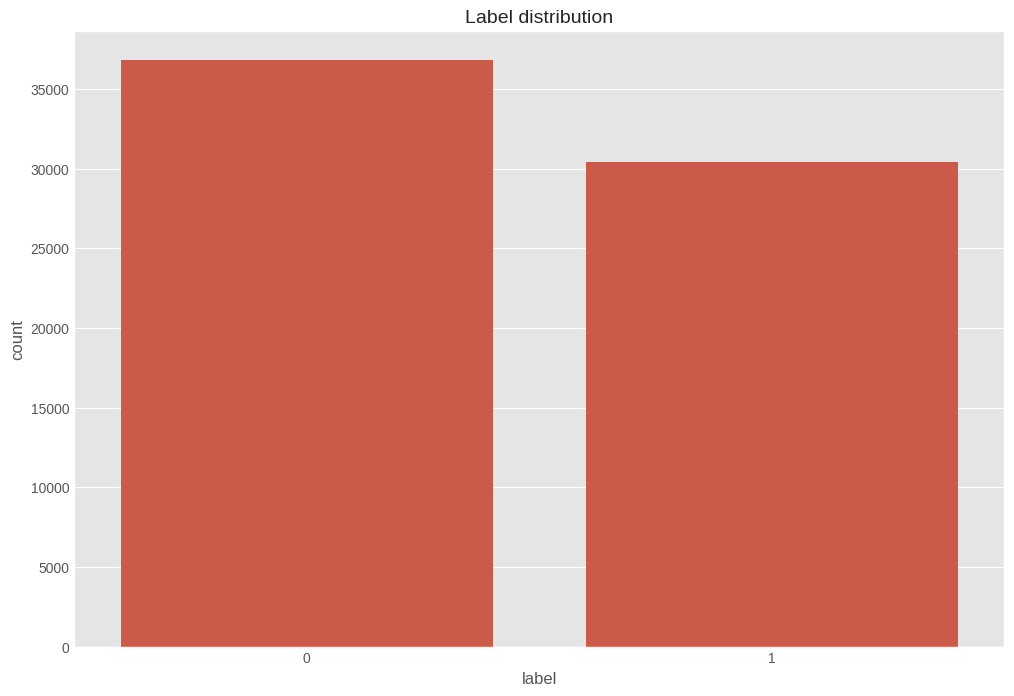

In [ ]:
#result is a dataset with a binary class label
plt.style.use('ggplot')
plt.figure(figsize=(12, 8))
sns.countplot(data = df, x='label')
plt.title('Label distribution', fontsize = 14)
plt.show()

In [ ]:
#view dataframe with revised label
df.head()

,text,label
0,That game hurt.,0
1,Man I love reddit.,1
2,"[NAME] was nowhere near them, he was by the Fa...",0
3,Right? Considering itâs such an important do...,1
4,"He isn't as big, but he's still quite popular....",0


In [ ]:
#Create a WordNetLemmatizer
lm = WordNetLemmatizer()

In [ ]:
#after implementing lemmatizer, the code will clean the text and make it a new text body
#by throwing away the root words. Transforming and reformatiting the whole text body.
def text_transformation(df_col):
  corpus = []
  for item in df_col:
    #remove punctuation characters
    new_item = re.sub('[^a-zA-Z]', '',str(item))
    #convert to lower case
    new_item = new_item.lower()
    new_item = new_item.split()
    #lemmatize and reomve stop words
    new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('english'))]
    #append to corpus and return as a transformed corpus
    corpus.append(' '.join(str(x) for x in new_item))
  return corpus

In [ ]:
#assign transformed text to the corpus
import nltk
nltk.download('omw-1.4')
corpus = text_transformation(df['text'])

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


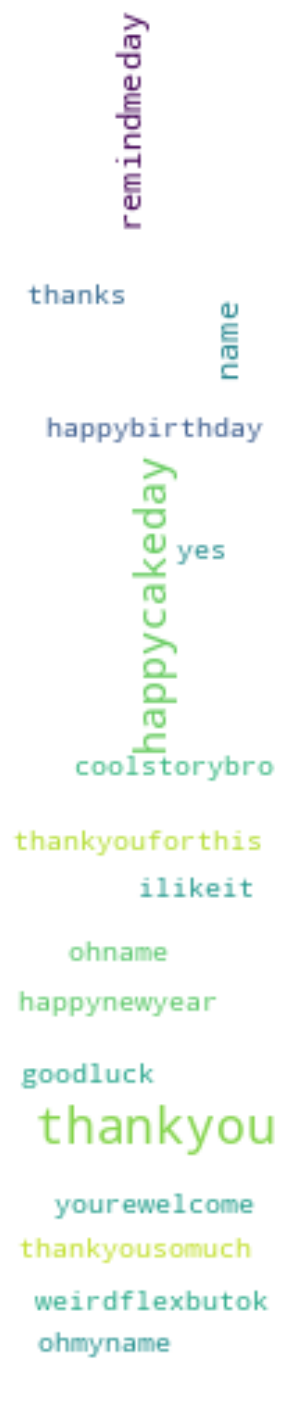

In [ ]:
#create a wordclod to show density
from wordcloud import WordCloud
import matplotlib.pyplot as plt


#combine all documents into a single string
word_cloud = ' '.join(corpus)

#create a wordcloud object
wordcloud = WordCloud(width=100, height=500, background_color='white', min_font_size=10).generate(word_cloud)

#plot the wordCloud image
plt.figure(figsize=(20,18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
#import CountVectorizer to create a Bag of Words (BOW) model
#This assists in determining the number of times each word appears
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#create a bigram with range (1,2) to permit dual word combinations
cv = CountVectorizer(ngram_range=(1,2))
data = cv.fit_transform(corpus)

In [ ]:
#assign x and y
X = data
y = df.label

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

In [ ]:
#Create a logistic regression model
model = LogisticRegression(max_iter=X_train.shape[1])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
accuracy_score(y_test, y_pred)

0.6121774841532006

In [ ]:
X_test, y_test = df.text, df.label
#encode the labels into two classes, 0 and 1
df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = model.predict(testdata)

In [ ]:
#load test data
test_df = pd.read_csv('test (1).csv', delimiter=';',names=['text','label'])
test_df

,text,label
0,didnt feel humiliated,"sadness,,,"
1,can go from feeling so hopeless to so damned h...,"sadn,,ess,"
2,m grabbing a minute to post i feel greedy wrong,"anger,,,"
3,am ever feeling nostalgic about the fireplace ...,"love,,,"
4,am feeling grouchy,"anger,,,"
...,...,...
15995,just had a very brief time in the beanbag and ...,"sadness,,,"
15996,am now turning and i feel pathetic that i am s...,"sadness,,,"
15997,feel strong and good overall,"joy,,,"
15998,feel like this was such a rude comment and im ...,"anger,,,"


In [ ]:
X_test, y_test = test_df.text, test_df.label
#encode the labels into two classes, 0 and 1
test_df = custom_encoder(y_test)
#pre-processing of text
test_corpus = text_transformation(X_test)
#convert text data into vectors
testdata = cv.transform(test_corpus)
#predict the target
predictions = model.predict(testdata)

Acccuracy score:  0.1359375
Precision score:  <function precision_score at 0x7dab3c9e4a40>
Recall score:  <function recall_score at 0x7dab3c9e4b80>
---------------------------------------------
              precision    recall  f1-score   support

    ,,anger,       0.00      0.00      0.00         7
     ,,fear,       0.00      0.00      0.00        12
      ,,joy,       0.00      0.00      0.00        28
     ,,love,       0.00      0.00      0.00         8
  ,,sadness,       0.00      0.00      0.00        24
 ,,surprise,       0.00      0.00      0.00         3
      ,anger       0.00      0.00      0.00         9
       ,fear       0.00      0.00      0.00         5
        ,joy       0.00      0.00      0.00        15
       ,love       0.00      0.00      0.00         7
    ,sadness       0.00      0.00      0.00        20
   ,surprise       0.00      0.00      0.00         6
           0       0.14      1.00      0.24      2175
           1       0.00      0.00      0.00      

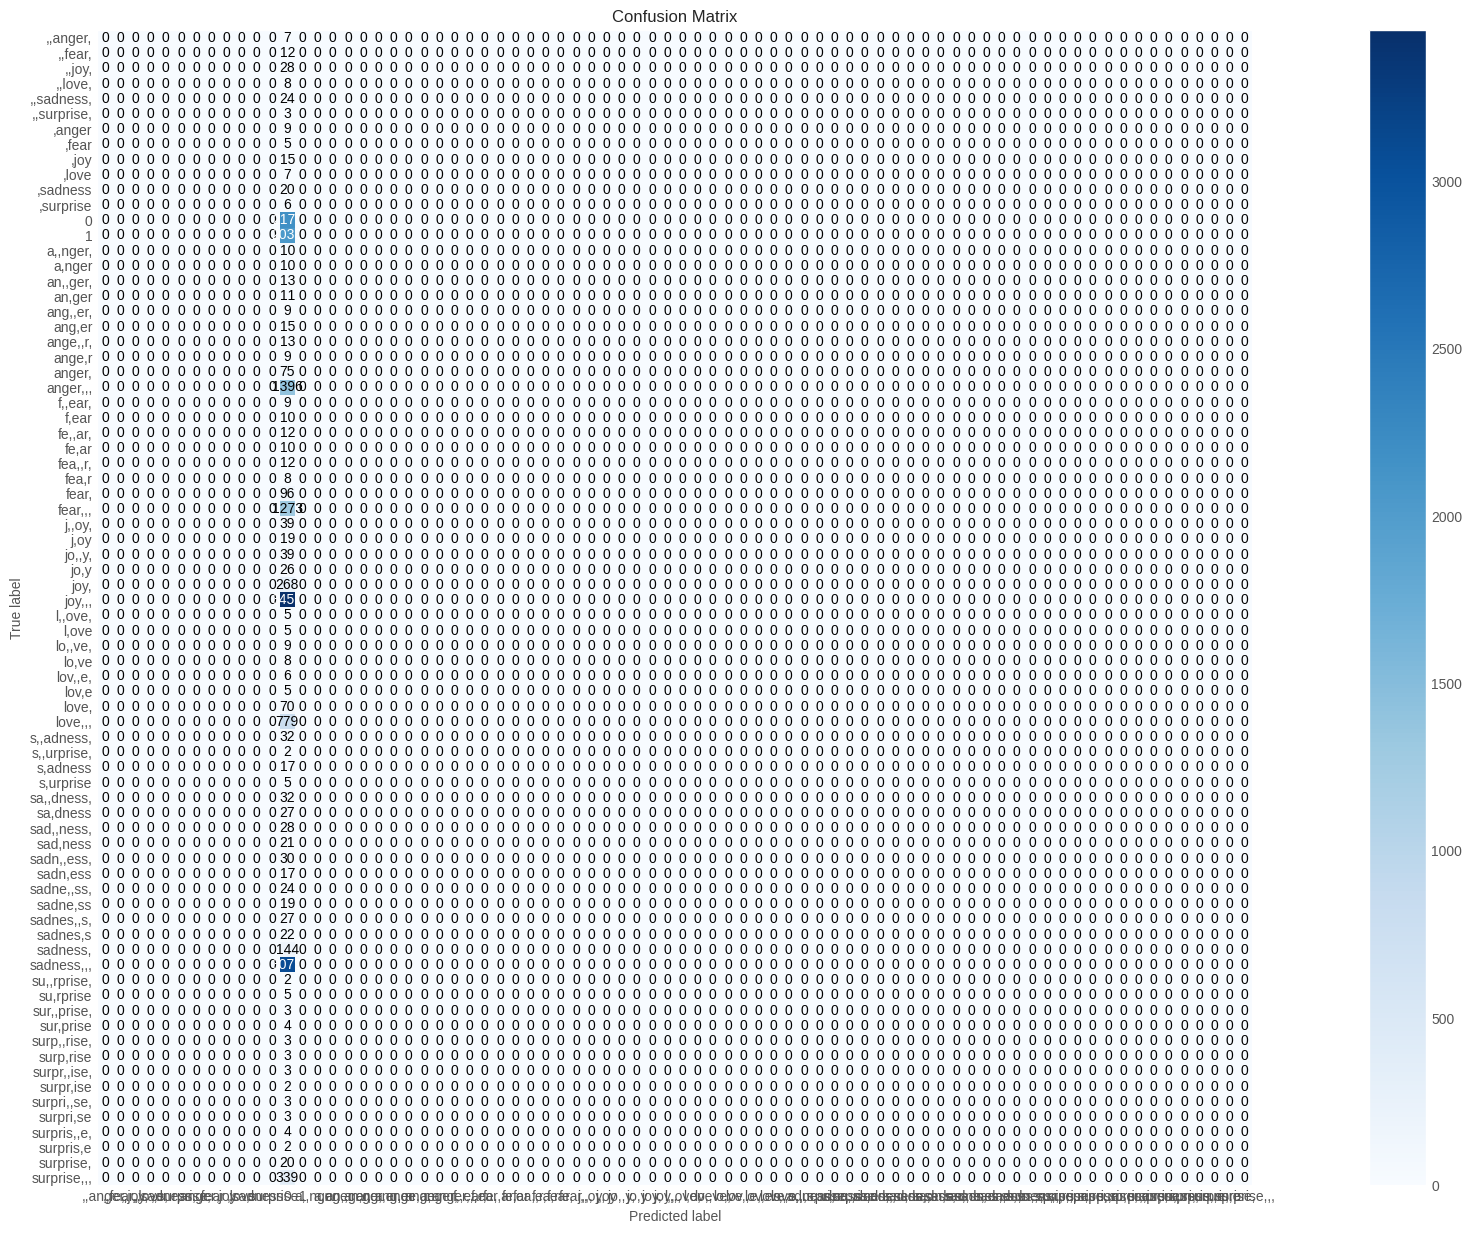

In [ ]:
from scikitplot.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from matplotlib import rcParams
#convert numeric target variable to strings if needed
y_test = y_test.astype(str)
predictions = predictions.astype(str)

rcParams['figure.figsize'] = 30, 15
plot_confusion_matrix(y_test, predictions)
acc_score = accuracy_score(y_test, predictions)
pre_score = precision_score(y_test, predictions, average='weighted')
rec_score = recall_score(y_test, predictions, average='weighted')
print('Acccuracy score: ', acc_score)
print('Precision score: ', precision_score)
print('Recall score: ', recall_score)
print('---------------------------------------------')
cr = classification_report(y_test, predictions)
print(cr)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report
#set the figure size
rcParams['figure.figsize'] = 10, 5

y_test = np.array(['label'])
predictions = np.array(['label'])

#plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):

  #compute accuracy, precision, and recall scores
  acc_score = accuracy_score(y_test, predictions)
  pre_score = precision_score(y_test, predictions, average='weighted')
  rec_score = recall_score(y_test, predictions, average='weighted')

  print('Acccuracy score: ', acc_score)
  print('Precision score: ', pre_score)
  print('Recall score: ', recall_score)
  print('----------------')
  cr = classification_report(y_test, predictions)
  print(cr)

In [ ]:
def expression_check(predicition_input):
  if predicition_input == 0:
    print('Input statement has Negative Sentiment.')
  elif predicition_input == 1:
    print('Input statement has Positive Sentiment.')
  else:
    print('Invalid Statement.')

In [ ]:
def sentiment_predictor(input):
  input = text_transformation(input)
  transformed_input = cv.transform(input)
  prediction = model.predict(transformed_input)
  expression_check(prediction)

In [ ]:
input1 = ['I am so sad']
input2 = ['I love you']
sentiment_predictor(input1)
sentiment_predictor(input2)


Input statement has Negative Sentiment.
Input statement has Positive Sentiment.
